# Shipping turn-around time

## Notebook set-up

In [1]:
import os
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import randint, uniform, loguniform
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, ShuffleSplit
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

import helper_functions as funcs

## 1. Data loading

In [2]:
with open('../data/processed/turnaround_time.pkl', 'rb') as input_file:
    turnaround_data = pickle.load(input_file)

## 2. Data inspection

In [3]:
training_df = turnaround_data['training']
testing_df = turnaround_data['testing']

training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6849 entries, 0 to 6848
Columns: 254 entries, 1 to Turnaround_Time
dtypes: float64(253), int64(1)
memory usage: 13.3 MB


In [4]:
training_df.head()

,1,Ship_Mode_First Class,Ship_Mode_Same Day,Ship_Mode_Second Class,Ship_Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Region_Central,Region_East,...,Order_Day_sin Order_Day_cos,Order_Day_sin Order_Month_Sin,Order_Day_sin Order_Month_Cos,Order_Day_cos^2,Order_Day_cos Order_Month_Sin,Order_Day_cos Order_Month_Cos,Order_Month_Sin^2,Order_Month_Sin Order_Month_Cos,Order_Month_Cos^2,Turnaround_Time
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.487464,-7.818315e-01,-1.436201e-16,0.388740,-6.234898e-01,-1.145332e-16,1.000000e+00,1.836970e-16,3.374460e-32,4
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,-0.487464,7.818315e-01,1.436201e-16,0.388740,-6.234898e-01,-1.145332e-16,1.000000e+00,1.836970e-16,3.374460e-32,6
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,-0.390916,-1.062709e-16,4.338837e-01,0.811745,2.206737e-16,-9.009689e-01,5.999039e-32,-2.449294e-16,1.000000e+00,6
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.487464,-3.909157e-01,6.770859e-01,0.388740,-3.117449e-01,5.399580e-01,2.500000e-01,-4.330127e-01,7.500000e-01,5
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.216942,-8.443123e-01,4.874640e-01,0.049516,-1.927088e-01,1.112605e-01,7.500000e-01,-4.330127e-01,2.500000e-01,2


In [5]:
training_df.describe()

,1,Ship_Mode_First Class,Ship_Mode_Same Day,Ship_Mode_Second Class,Ship_Mode_Standard Class,Segment_Consumer,Segment_Corporate,Segment_Home Office,Region_Central,Region_East,...,Order_Day_sin Order_Day_cos,Order_Day_sin Order_Month_Sin,Order_Day_sin Order_Month_Cos,Order_Day_cos^2,Order_Day_cos Order_Month_Sin,Order_Day_cos Order_Month_Cos,Order_Month_Sin^2,Order_Month_Sin Order_Month_Cos,Order_Month_Cos^2,Turnaround_Time
count,6849.0,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,6849.000000,...,6849.000000,6849.000000,6849.000000,6849.000000,6.849000e+03,6.849000e+03,6.849000e+03,6.849000e+03,6.849000e+03,6849.000000
mean,1.0,0.154913,0.055775,0.191999,0.597313,0.523872,0.299314,0.176814,0.233173,0.281063,...,0.042762,0.016694,-0.012031,0.453924,-3.047110e-02,2.198247e-02,4.772595e-01,-7.239006e-02,5.227405e-01,3.956052
std,0.0,0.361848,0.229503,0.393901,0.490474,0.499466,0.457991,0.381539,0.422882,0.449551,...,0.354118,0.511616,0.532899,0.347397,4.630017e-01,4.880651e-01,3.751500e-01,3.217774e-01,3.751500e-01,1.754158
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.487464,-0.974928,-0.974928,0.049516,-1.000000e+00,-1.000000e+00,1.499760e-32,-4.330127e-01,3.749399e-33,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.216942,-0.390916,-0.390916,0.049516,-3.117449e-01,-3.117449e-01,2.500000e-01,-4.330127e-01,2.500000e-01,3.000000
50%,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.388740,-2.725095e-17,3.817774e-17,2.500000e-01,-2.449294e-16,7.500000e-01,4.000000
75%,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,...,0.390916,0.390916,0.390916,0.811745,2.225209e-01,4.504844e-01,7.500000e-01,1.836970e-16,7.500000e-01,5.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.487464,0.974928,0.974928,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,4.330127e-01,1.000000e+00,7.000000


## 3. Linear regression

Training R² = 0.694
Training RMSE = 0.970

Testing R² = 0.679
Testing RMSE = 0.985



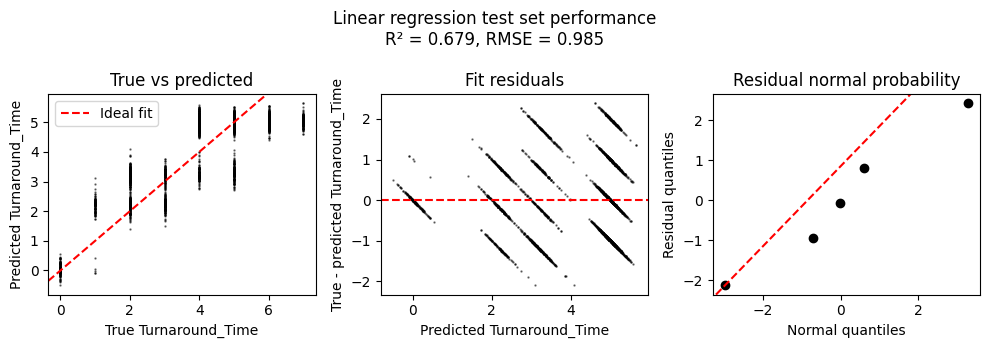

In [6]:
linear_model = funcs.train_evaluate_model(
    model=LinearRegression(),
    train_df=training_df,
    test_df=testing_df,
    label='Turnaround_Time',
    plot_title='Linear regression test set performance',
    log_axes=False
)

## 4. Feature importance

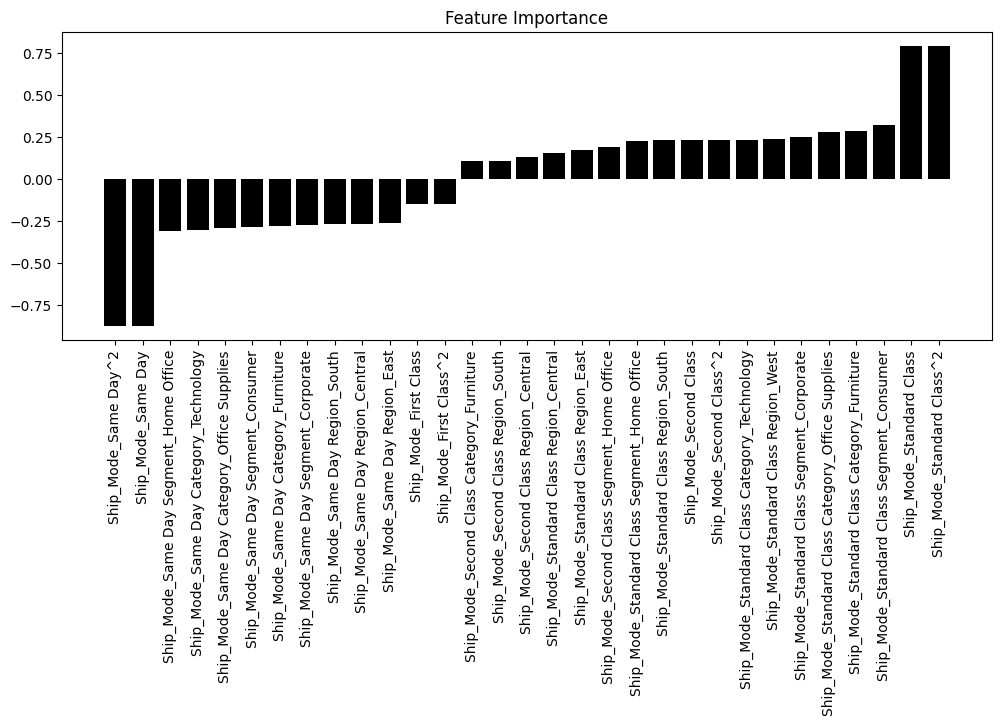

In [15]:
importance = pd.DataFrame({
    'Feature': training_df.drop('Turnaround_Time', axis=1).columns,
    'Importance': linear_model.coef_
})

importance = importance[(importance['Importance'] > 0.1) | (importance['Importance'] < -0.1)]

importance.sort_values(by='Importance', inplace=True)

fig, ax = plt.subplots(1,1, figsize=(12,4))

ax.set_title('Feature Importance')
ax.bar(importance['Feature'], importance['Importance'], color='black')
ax.tick_params('x', labelrotation=90)

## 5. Gradient boosting

Training R² = 0.732
Training RMSE = 0.907

Testing R² = 0.699
Testing RMSE = 0.954



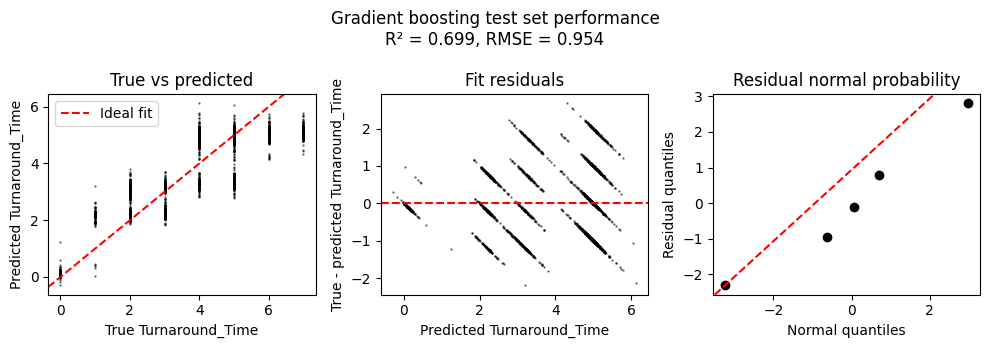

In [8]:
gbt_model = funcs.train_evaluate_model(
    model=GradientBoostingRegressor(),
    train_df=training_df,
    test_df=testing_df,
    label='Turnaround_Time',
    plot_title='Gradient boosting test set performance',
    log_axes=False
)

## 6. Hyperparameter optimization

In [9]:
# Cross validation strategy
CV_FOLDS = 10
CV_SPLIT = 0.5

CROSS_VAL = ShuffleSplit(
    n_splits=CV_FOLDS,
    test_size=CV_SPLIT,
    random_state=315
)

In [10]:
%%time

# Define hyperparameter search space for gradient boosting optimization
hyperparameters = {
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'learning_rate': loguniform(10**-5, 1.0),
    'n_estimators': randint(2, 300),
    'subsample': uniform(loc=0.1, scale=0.9),
    'criterion': ['friedman_mse', 'squared_error'],
    'min_samples_split': randint(2, 1000),
    'min_samples_leaf': randint(1, 1000),
    'min_weight_fraction_leaf': uniform(loc=0.0, scale=0.5),
    'max_depth': randint(1, 50),
    'min_impurity_decrease': loguniform(10**-10, 10.0),
    'max_features':uniform(loc=0.1, scale=0.9)
}

# Perform randomized search over hyperparameters
search = RandomizedSearchCV(
    GradientBoostingRegressor(),
    hyperparameters,
    return_train_score=True, # Return training scores for analysis
    cv=CROSS_VAL,            # Use stratified shuffle split for cross-validation
    n_jobs=-1,               # Use all available CPU cores
    n_iter=50,               # Number of parameter combinations to try
    random_state=315         # Ensure reproducible results
)

# Fit the search and extract best model and parameters
search_results = search.fit(training_df.drop('Turnaround_Time', axis=1), training_df['Turnaround_Time'])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

print(f'Run time ({os.cpu_count()} CPUs):\n')

Best hyperparameters:

 criterion: friedman_mse
 learning_rate: 0.916195726238059
 loss: absolute_error
 max_depth: 15
 max_features: 0.12087436093752943
 min_impurity_decrease: 1.2232761814181105e-07
 min_samples_leaf: 360
 min_samples_split: 171
 min_weight_fraction_leaf: 0.10867160049935443
 n_estimators: 41
 subsample: 0.6068699978828815

Run time (20 CPUs):

CPU times: user 1.8 s, sys: 139 ms, total: 1.93 s
Wall time: 31.3 s


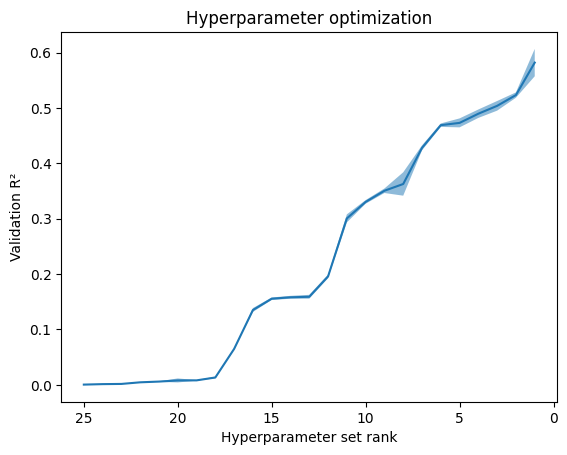

In [11]:
funcs.plot_cross_validation(search_results)

Training R² = 0.657
Training RMSE = 1.027

Testing R² = 0.626
Testing RMSE = 1.063



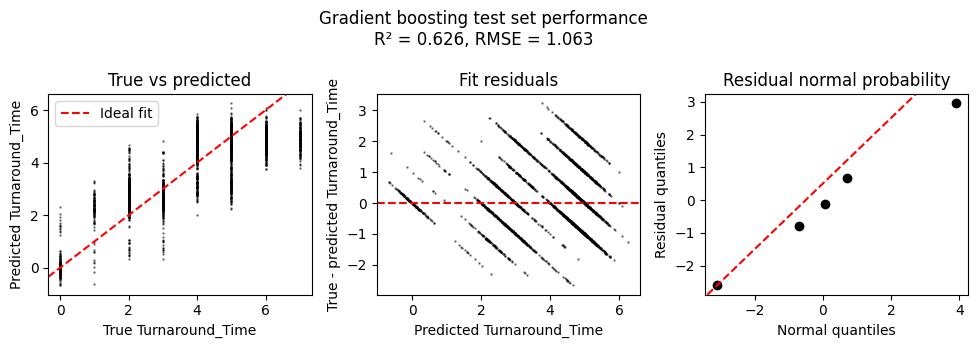

In [12]:
best_gbt_model = funcs.train_evaluate_model(
    model=best_model,
    train_df=training_df,
    test_df=testing_df,
    label='Turnaround_Time',
    plot_title='Gradient boosting test set performance',
    log_axes=False
)